Slide 1
<!--- ![](../reports/presentations/20231205/1.png) -->

# Pipeline

Slides 2-4
<!--- ![](../reports/presentations/20231205/2.png)
![](../reports/presentations/20231205/3.png)
![](../reports/presentations/20231205/4.png)--->

## Setup

### Imports

In [1]:
# External imports
import os
import sys
import spacy
from sentence_transformers import SentenceTransformer

# Get the current working directory (assuming the notebook is in the notebooks folder)
current_dir = os.getcwd()

# Add the parent directory (project root) to the Python path
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)

# Relative imports
from src.utils import load_spacy, generate_paths
from src.preprocess import Preprocessor
from src.modelling import get_constraints_from_data
from src.evaluation import Evaluator
# from src.evaluation import cnstrnts_gs, sbert_smlarty, sbert_smlarty_cmpntns, evlt_prec_rec

/Users/leoh/Workspace/Anaconda/anaconda3/envs/nlp-rules/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Files

In [2]:
# Define use cases with their folder names and their file identifiers (without prefix); if folder name and file identifier are the same, a string instead of a tuple can be used
cases = {
    "AktG": "aktg",
    "CDM 01: A/R Mangroves": ("cdm", "cdm_01"),
    "CDM 02: A/R Non-wetlands": ("cdm", "cdm_02"),
    "CDM 03: Cable Cars": ("cdm", "cdm_03"),
    "CDM 04: Energy Efficiency": ("cdm", "cdm_04"),
    "CDM 05: Electriciy Generation": ("cdm", "cdm_05"),
    "Coffee": "coffee",
    "PatG": "patg",
}

# Generate file_paths for input and output
file_paths_input = generate_paths(cases, 'input')
file_paths_output = generate_paths(cases, 'output')

### Parameter

In [4]:
# spaCy model
# https://spacy.io/models/en
spacy_model = 'en_core_web_lg'

# Load the spaCy model
nlp = load_spacy(model=spacy_model)

# S-BERT model
# https://www.sbert.net/docs/pretrained_models.html
sbert_model = 'all-mpnet-base-v2'  # best performance
# sbert_model = 'all-MiniLM-L6-v2'    # one of the fastest with good performance

# Load the S-BERT model
model = SentenceTransformer(sbert_model)

# Define custom stop words
add_stpwrds = []
non_stpwrds = list(
    """
a above all amount and as at

be before below between beyond both by

can

each either else even except

for

i if 

last least less

may more most must 

name next no none not nothing

of on only otherwise over or out

per

same several should

than then to

under up

what when with
""".split()
)

# This is needed because spaCy struggles with linebreak characters, but the information is needed for the enumeration (see also https://github.com/explosion/spaCy/issues/7735)
linebreak = " NEWLINE "

# Define character sequences to replace
replace = {
    ",": " , ", # Remove this line if any numbers with thousands (e.g. 1,000.00)
    "\n\n": "\n", 
    "\n \n": "\n",
    "\n \n\n": "\n",
    "\n\n \n": "\n",
    "\n": linebreak,
    "   ": " ",
    "  ": " "
} 

# Define character sequences to remove
remove=["\t"]

# Patterns for different enumeration items types for regex matching (to split into chunks)
enum_patterns = {
    'number_in_parentheses': r"\(\d+\)",
    'number_with_dot': r"\d+\.",
    'alphabetical_in_parentheses': r"\([a-z]\)",
    'roman_numeral_in_parentheses': r"\([ivxlcdm]+\)",
}

# Patterns for different enumeration items types for spaCy matching (to label enumeration tokens)
# Every pattern has to follow a linebreak; additionally, the order of the pattern has to be followed (e.g., "v" as alphabetical_in_parentheses can only be a match, if the previous one was also alphabetical_in_parentheses 
enum_patterns_spacy = {
    'number_in_parentheses': [{"TEXT": "("}, {"IS_DIGIT": True}, {"TEXT": ")"}],
    'number_with_dot': [{"IS_DIGIT": True}, {"TEXT": "."}, {"IS_DIGIT": False}],
    'alphabetical_in_parentheses': [{"TEXT": "("}, {"TEXT": {"IN": ["a", "b", "c", "d", "e", "f", "g", "h"]}}, {"TEXT": ")"}],
    'roman_numeral_in_parentheses': [{"TEXT": "("}, {"TEXT": {"IN": ["i", "ii", "iii", "iv", "v", "vi", "vii", "viii"]}}, {"TEXT": ")"}],
}

no_digit_or_period = [{"TEXT": {"NOT_IN": ["."]}, "IS_DIGIT": False, "OP": "*"}]

# Define inequality matching parameters
inequality_params = {
    "general": {
        "below": "<",
        "less than": "<",
        "low than": "<",
        "small than": "<",
        "as high as": "<=",
        "at most": "<=",
        "up to": "<=",
        "remain at": "<=",
        "eligibility limit of": "<=",
        "above": ">",
        "beyond": ">",
        "exceed": ">",
        "great than": ">",
        "high than": ">",
        "more than": ">",
        "surpass": ">",
        "at least": ">="
    },
    "exceptions": {
    },
    "exception_patterns": {
        # coffee
        "reach_beyond": [{"LOWER": "reach"}] + no_digit_or_period + [{"LIKE_NUM": True}] + no_digit_or_period + [{"LOWER": "beyond"}],
        "low_allow": [{"LOWER": "low"}] + no_digit_or_period + [{"LOWER": "allow"}] + no_digit_or_period + [{"LIKE_NUM": True}],
        "between": [{"LOWER": "between"}, {"LIKE_NUM": True}] + no_digit_or_period + [{"LIKE_NUM": True}],
        "brackets": [{"TEXT": "["}, {"LIKE_NUM": True}, {"IS_DIGIT": False, "OP": "?"},{"IS_DIGIT": False, "OP": "?"},{"IS_DIGIT": False, "OP": "?"},{"LIKE_NUM": True},{"IS_DIGIT": False, "OP": "*"}, {"TEXT": "]"}],
        "parentheses": [{"TEXT": "("}, {"LIKE_NUM": True}, {"IS_DIGIT": False, "OP": "?"},{"IS_DIGIT": False, "OP": "?"},{"IS_DIGIT": False, "OP": "?"},{"LIKE_NUM": True},{"IS_DIGIT": False, "OP": "*"}, {"TEXT": ")"}]
    },
    "negation_operators": {
        "<": ">=",
        "<=": ">",
        ">": "<=",
        ">=": "<"
    },
    "negation_tokens": {"not", "no"},
    "window_size": (12, 0) # Very long
}

# Define equality matching parameters
equality_params = {
    "general": {
        "must": "==",
        "shall": "==",
        "should": "=="
    },
    "exceptions": {
        # aktg
        "be to set out": "==",
        "applicable under": "==",
        # cdm_01
        "apply to": "==",
        # cdm_02
        "applicable to": "==",
        # cdm_03
        "eligible under": "==",
        # cdm_04
        "allowable project include": "==",
        # cdm_05
        "category comprise": "==",
        "include category": "==",
        "be limit to": "==",
        # patg
        "be to be": "=="
    },
    "exception_patterns": {
        # aktg
        "may_only": [{"LOWER": "may"}] + no_digit_or_period + [{"LOWER": "only"}],
        # cdm_01
        "fall_in": [{"LOWER": "fall"}] + no_digit_or_period + [{"LOWER": "category"}],
        # cdm_04
        "none_may": [{"LOWER": "none"}] + no_digit_or_period + [{"LOWER": "may"}],
    },
    "negation_operators": {
        "==": "!="
    },
    "negation_tokens": {"not", "no"},
    "window_size": (3, 2)
}

# Define meta matching parameters
# Due to the complex nature of the meta constraint searching process, some meta parametesr are also implicitly set within the MetaConstraintSearcher class
meta_params = {
    "enum_exceptions": {
        # cdm 02
        "be include": "OR",
        # cdm 05
        "at least one of": "OR"
    },
    "if_patterns": {
        "if_then": [{"LOWER": "if"}, {"TEXT": {"NOT_IN": [":",".",";"]}, "OP": "*"},{"TEXT": {"IN": [","]}, "OP": "?"}, {"LOWER": "then"}],
        "if_comma": [{"LOWER": "if"}, {"TEXT": {"NOT_IN": [":",".",";"]}, "OP": "*"},{"TEXT": {"IN": [","]}}, {"TEXT": {"NOT_IN": ["then"]}}],
        "if_case_of_comma": [{"LOWER": "case"}, {"LOWER": "of"}, {"TEXT": {"NOT_IN": [":",".",";"]}, "OP": "*"},{"TEXT": {"IN": [","]}}, {"TEXT": {"NOT_IN": ["then"]}}],
        
    },
    "for_patterns": {
        "for_colon": [{"LOWER": "for"}, {"TEXT": {"NOT_IN": [".",";",",", "for"]}, "OP": "*"},{"TEXT": {"IN": [":"]}}],
        "for_comma": [{"LOWER": "for"}, {"TEXT": {"NOT_IN": [":",".",";","for", ",", "---"]}, "OP": "*"},{"TEXT": {"IN": [","]}}, {"TEXT": {"NOT_IN": ["if"]}}]
    },
    "connectors": {
        "and": "AND",
        "and or": "OR",
        "or": "OR",
        "except when": "OR",
        # ";": "AND",
    },
    # Format is (pattern_name, matching_pattern): connector
    "connector_exception_pattern": {
        "semicolon": (";","AND"),
        "period": (".","AND")
    },
    "negation_tokens": {"not", "no"},   # Used for if_patterns
    "window_size": (0, 5),              # Used for if_patterns
    "context_limits": [".", ";"]
}

The model en_core_web_lg is already installed!


## Preprocessing

In [5]:
# Create preprocessing object
pp = Preprocessor(nlp, file_paths_input, verbose=False)

# Add and remove custom stop words globally to the spacy.util.get_lang_class('en')
_ = pp.chng_stpwrds(add=add_stpwrds,remove=non_stpwrds, remove_numbers=True)

# Process all files
data = pp.optimized_preprocessing(replace, remove, linebreak, enum_patterns, enum_patterns_spacy)

# Restore the default set of stpwrds for the constraint building
_ = pp.chng_stpwrds(restore_default=True)

## Modelling

### Constraint Search

In [6]:
constraints = get_constraints_from_data(nlp, data, equality_params, inequality_params, meta_params, verbose=True)


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 

AKTG 

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 


++++ CHUNK ++++ 

<

++++ CHUNK ++++ 

-- source : - > Stock Corporation Act of 6 September 1965 ( Federal Law Gazette I , p. 1089 ) , as last amend by Article 7 of Act of 22 February 2023 ( Federal Law Gazette 2023 I no

++++ CHUNK ++++ 

51 ) , https://www.gesetze-im-internet.de/englisch_aktg/englisch_aktg.html , access Jan 15 2024 - > >

++++ CHUNK ++++ 

establishment of by - law
 ( 1 ) by - law must be establish by way of be record by a notary

  id  type    match     pattern    exception    negation       symbol      level  predecessor    successor      context
----  ------  --------  ---------  -----------  -------------  --------  -------  -------

## Evaluation


AKTG

Precision: 0.2531002144018809
Maximum precision: 1.0
Recall: 0.18982516080141065
Maximum recall: 0.75

CDM 01: A/R MANGROVES

Precision: 0.3299399976929029
Maximum precision: 1.0
Recall: 0.19796399861574174
Maximum recall: 0.6

CDM 02: A/R NON-WETLANDS

Precision: 0.3278230473399162
Maximum precision: 1.0
Recall: 0.3278230473399162
Maximum recall: 1.0

CDM 03: CABLE CARS

Precision: 0.24290577471256256
Maximum precision: 1.0
Recall: 0.24290577471256256
Maximum recall: 1.0

CDM 04: ENERGY EFFICIENCY

Precision: 0.2632135474681854
Maximum precision: 1.0
Recall: 0.2632135474681854
Maximum recall: 1.0

CDM 05: ELECTRICIY GENERATION

Precision: 0.28607660640369764
Maximum precision: 1.0
Recall: 0.2247744764600481
Maximum recall: 0.7857142857142857

COFFEE

Precision: 0.3434990348815918
Maximum precision: 1.0
Recall: 0.33028753353999213
Maximum recall: 0.9615384615384616

PATG

Precision: 0.33528473824262617
Maximum precision: 1.0
Recall: 0.33528473824262617
Maximum recall: 1.0


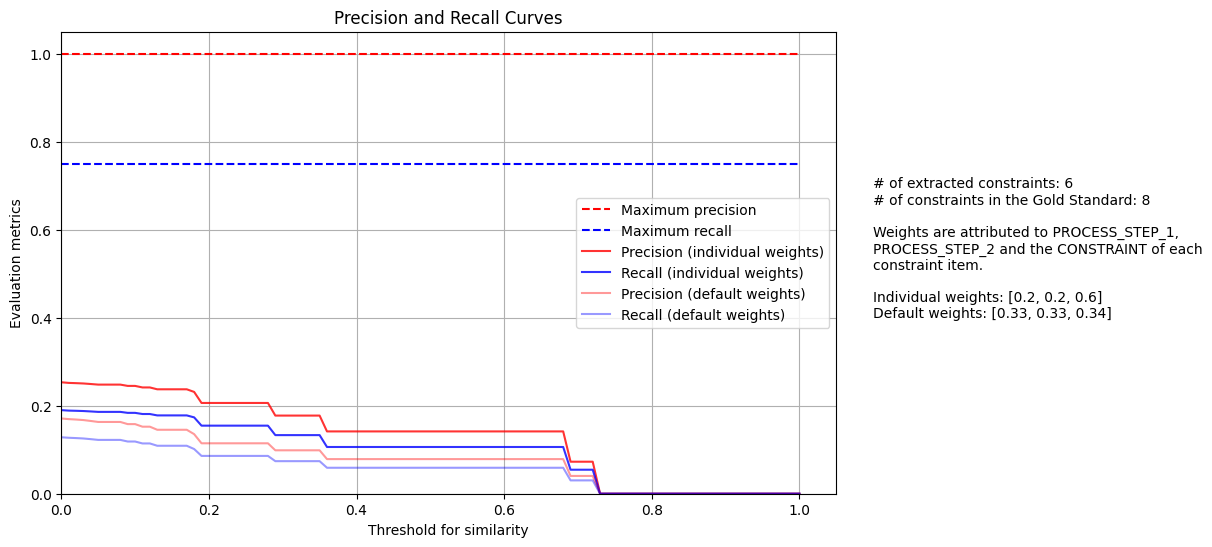

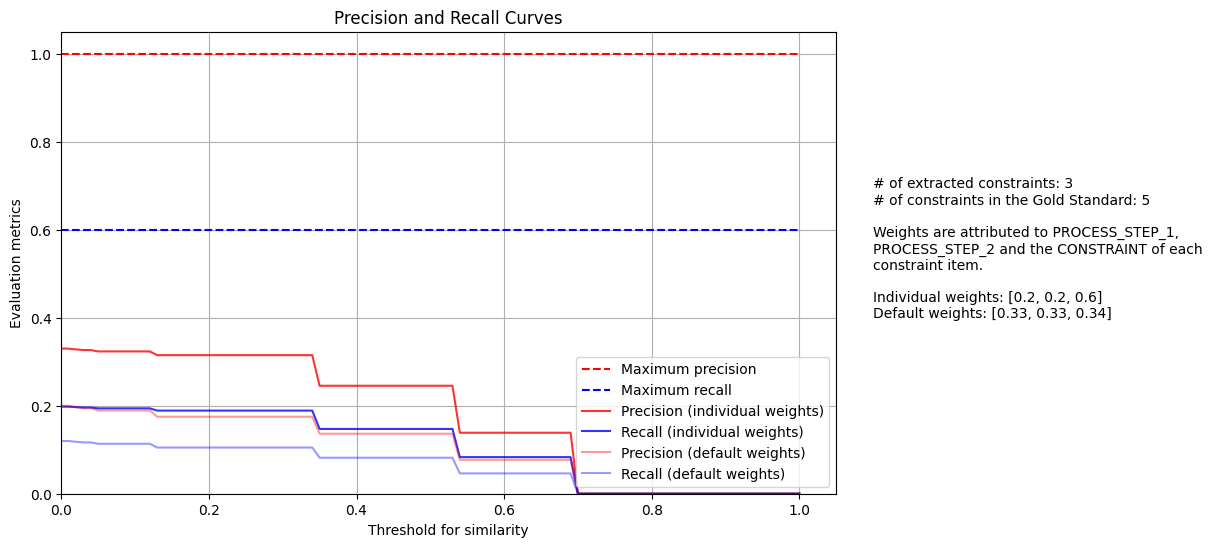

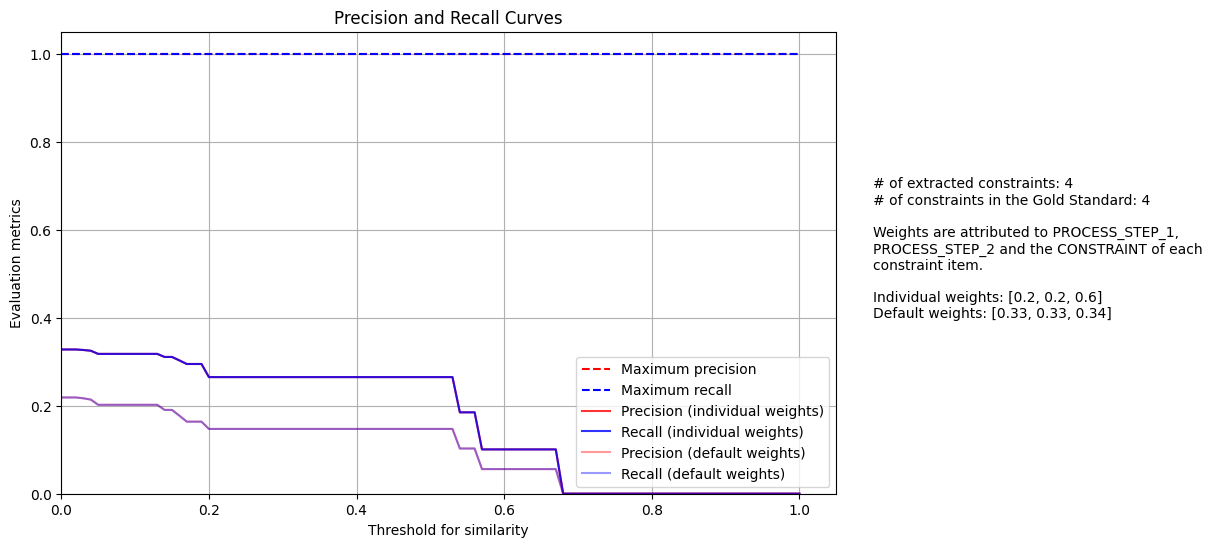

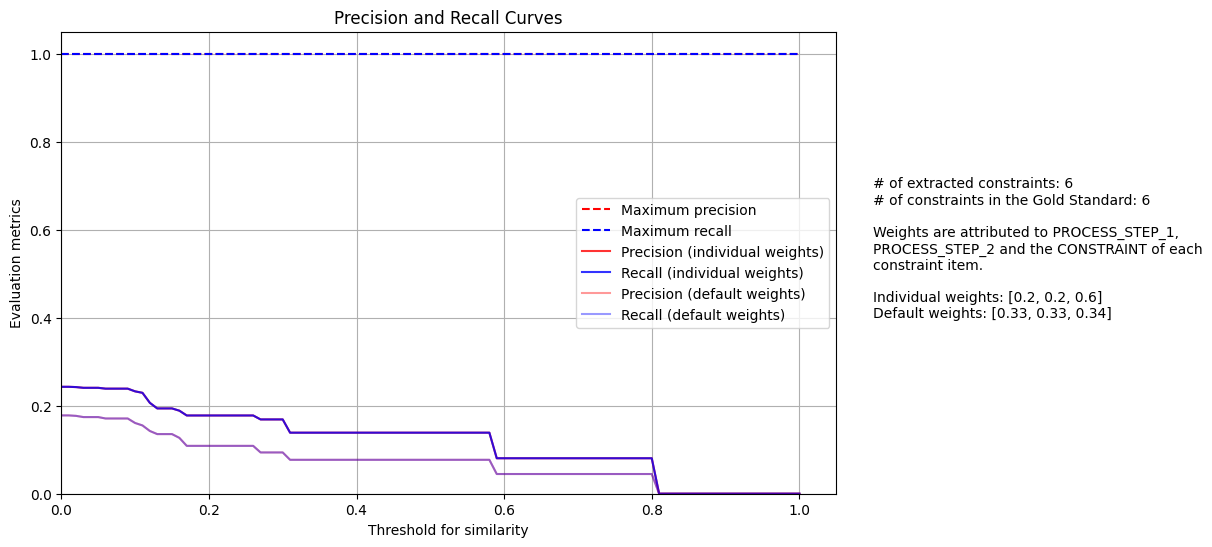

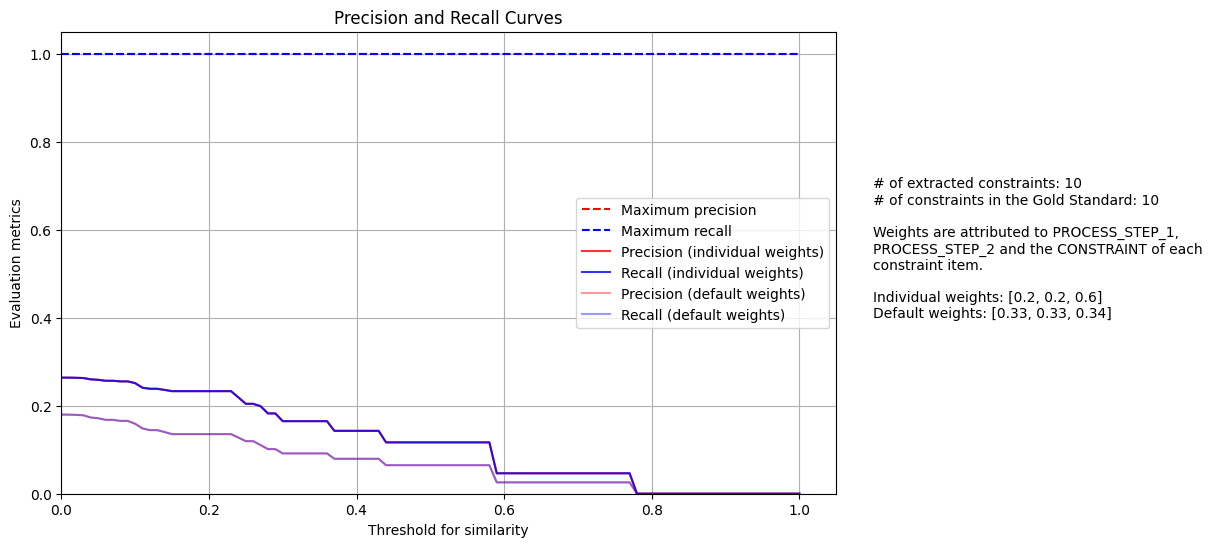

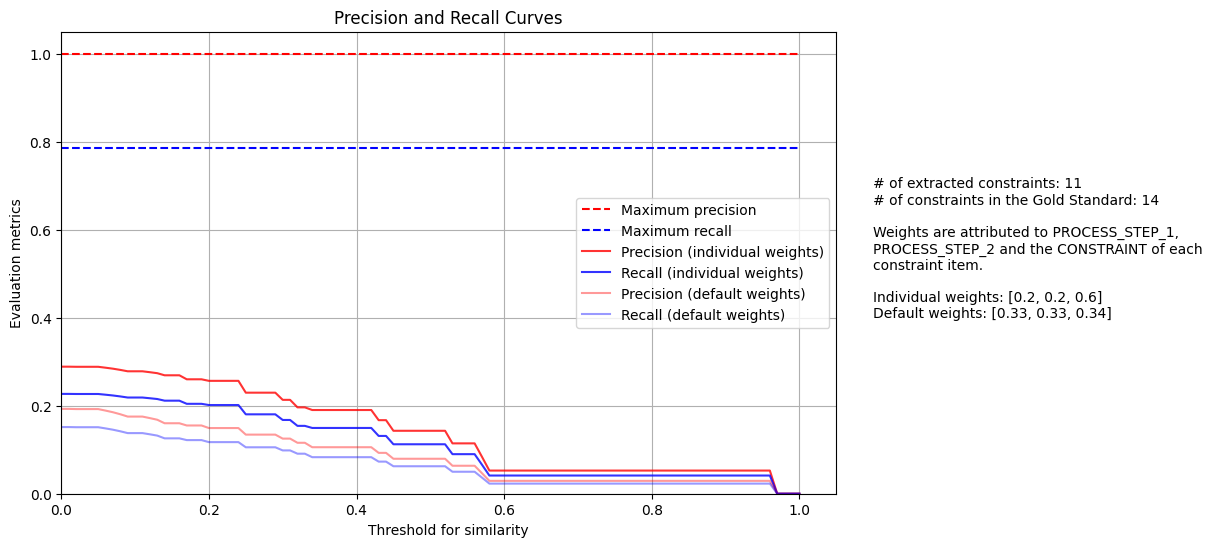

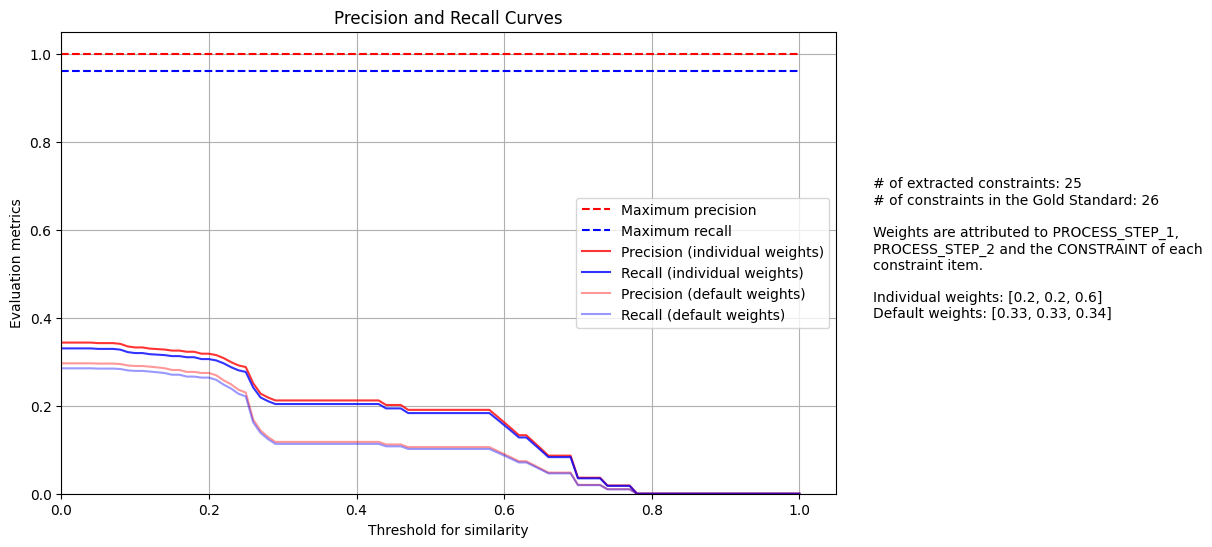

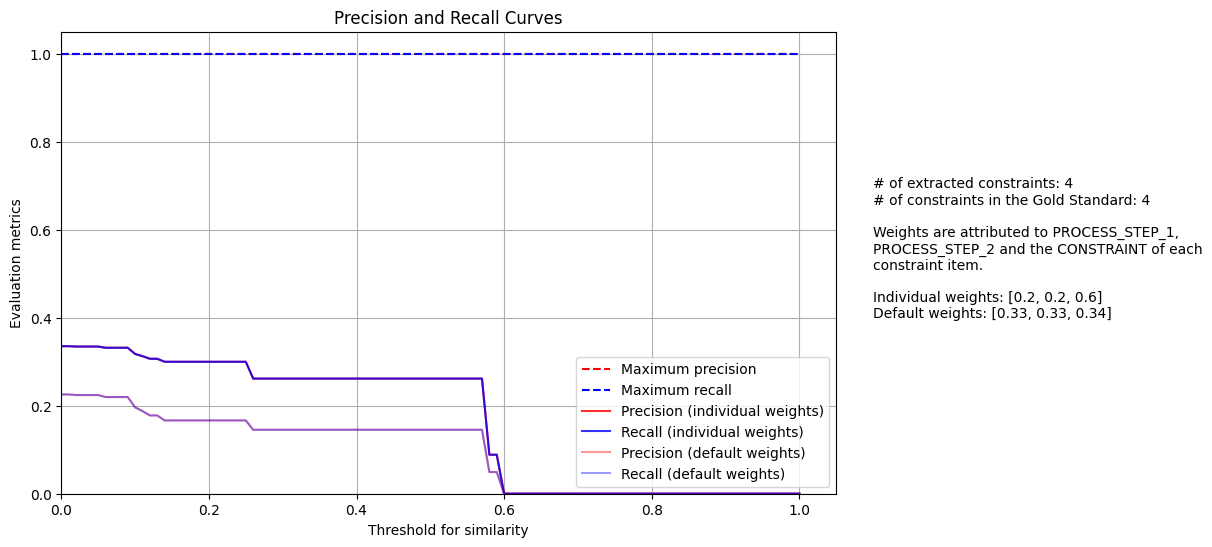

In [8]:
evaluator = Evaluator(model, constraints, [], file_paths_output, True)
evaluator.evaluate_all()

Final Slides
<!-- 
![](../reports/presentations/20231205/5.png)
![](../reports/presentations/20231205/6.png) 
![](../reports/presentations/20231205/7.png)-->